In [1]:
def func(x):
  return x**2

def func_grad(x):
  return 2*x

RMSpropNesterov final parameters: [-5.47618275e-05  1.25097405e-08]


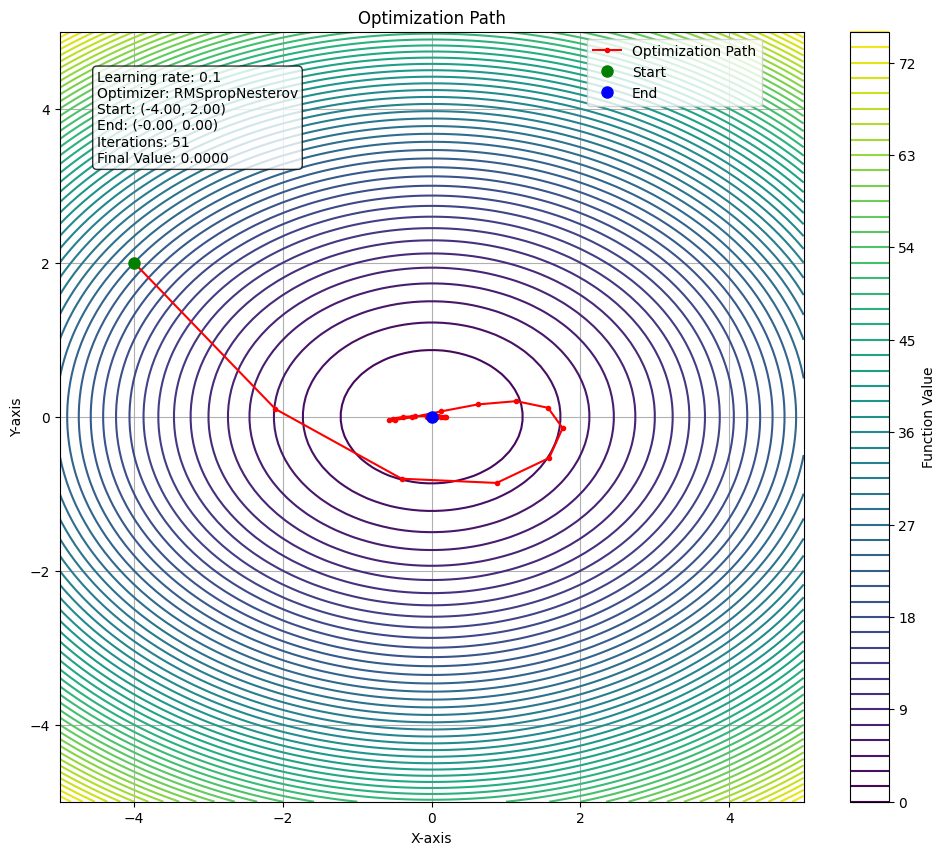

In [2]:
from typing import Callable, List, Tuple, Dict, Any
import numpy as np
import matplotlib.pyplot as plt

class Optimizer:
    """کلاس پایه برای بهینه‌سازها"""
    def __init__(self, learning_rate: float):
        self.learning_rate = learning_rate

    def update(self, params: np.ndarray, grads: np.ndarray, state: Dict[str, Any]) -> Tuple[np.ndarray, Dict[str, Any]]:
        raise NotImplementedError("این متد باید در کلاس‌های فرزند پیاده‌سازی شود.")

class RMSpropNesterov(Optimizer):
    """بهینه‌ساز آر ام اس پروپ با نستروا (RMSprop with Nesterov Momentum)"""
    def __init__(self, learning_rate: float, decay_rate: float = 0.99, momentum: float = 0.9, epsilon: float = 1e-8):
        super().__init__(learning_rate)
        self.decay_rate = decay_rate
        self.momentum = momentum
        self.epsilon = epsilon

    def update(self, params: np.ndarray, grads: np.ndarray, state: Dict[str, Any]) -> Tuple[np.ndarray, Dict[str, Any]]:
        # ایجاد حالت اولیه برای میانگین متحرک مربع گرادیان و سرعت اگر وجود نداشته باشد
        if 'square_grad' not in state:
            state['square_grad'] = np.zeros_like(params)  # میانگین متحرک مربع گرادیان
            state['velocity'] = np.zeros_like(params)    # سرعت برای Nesterov momentum
        
        # به‌روزرسانی میانگین متحرک مربع گرادیان
        state['square_grad'] = self.decay_rate * state['square_grad'] + (1 - self.decay_rate) * grads**2
        
        # محاسبه سرعت با استفاده از Nesterov momentum
        velocity_prev = state['velocity']
        state['velocity'] = self.momentum * velocity_prev - self.learning_rate / (np.sqrt(state['square_grad']) + self.epsilon) * grads
        
        # به‌روزرسانی پارامترها
        return params + self.momentum * state['velocity'] - self.learning_rate / (np.sqrt(state['square_grad']) + self.epsilon) * grads, state

def optimize(optimizer: Optimizer, initial_params: np.ndarray, grad_func: Callable, 
             num_iterations: int) -> List[np.ndarray]:
    """اجرای فرآیند بهینه‌سازی"""
    params = initial_params
    state = {}
    trajectory = [params.copy()]
    
    for _ in range(num_iterations):
        grads = grad_func(params)
        params, state = optimizer.update(params, grads, state)
        trajectory.append(params.copy())
    
    return trajectory

def plot_contour_and_trajectory(func: Callable, trajectory: List[np.ndarray], optimizer_name: str, learning_rate: float):
    """رسم نمودار کانتور تابع هدف و مسیر بهینه‌سازی"""
    x = np.linspace(-5, 5, 100)
    y = np.linspace(-5, 5, 100)
    X, Y = np.meshgrid(x, y)
    Z = func(np.array([X, Y]))

    plt.figure(figsize=(12, 10))
    contour = plt.contour(X, Y, Z, levels=50, cmap='viridis')
    plt.colorbar(contour, label='Function Value')
    
    trajectory = np.array(trajectory)
    plt.plot(trajectory[:, 0], trajectory[:, 1], 'ro-', linewidth=1.5, markersize=3, label='Optimization Path')
    plt.plot(trajectory[0, 0], trajectory[0, 1], 'go', label='Start', markersize=8)
    plt.plot(trajectory[-1, 0], trajectory[-1, 1], 'bo', label='End', markersize=8)
    
    plt.legend(bbox_to_anchor=(0.7, 1), loc='upper left')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.title('Optimization Path')
    plt.grid(True)
    
    # اطلاعات تکمیلی
    info_text = f"Learning rate: {learning_rate}\n"
    info_text += f"Optimizer: {optimizer_name}\n"
    info_text += f"Start: ({trajectory[0, 0]:.2f}, {trajectory[0, 1]:.2f})\n"
    info_text += f"End: ({trajectory[-1, 0]:.2f}, {trajectory[-1, 1]:.2f})\n"
    info_text += f"Iterations: {len(trajectory)}\n"
    info_text += f"Final Value: {func(trajectory[-1]):.4f}"
   
    plt.text(0.05, 0.95, info_text, transform=plt.gca().transAxes, 
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.show()

# تعریف تابع هدف و گرادیان آن
def objective_function(params: np.ndarray) -> float:
    return params[0]**2 + 2 * params[1]**2

def gradient_function(params: np.ndarray) -> np.ndarray:
    return np.array([2 * params[0], 4 * params[1]])

# مثال استفاده
if __name__ == "__main__":
    initial_params = np.array([-4.0, 2.0])
    num_iterations = 50
    learning_rate = 0.1

    optimizer = RMSpropNesterov(learning_rate)
    trajectory = optimize(optimizer, initial_params, gradient_function, num_iterations)
    print(f"RMSpropNesterov final parameters: {trajectory[-1]}")
    plot_contour_and_trajectory(objective_function, trajectory, "RMSpropNesterov", learning_rate)